In [1]:
import tqdm
import numpy as np
import cv2
import glob

In [2]:
# 1. add camera movement across the desk plane (grid movements)
# 2. save photos from each device to specified directories (kinect, realsense & huawei)
# 3. count intrinsics and remove distortion for each camera (use calibrate_with_img)
# 4. count extrinsics for device pairs (kinect-realsense, realsense-huawei, huawei-kinect) (implement method)
# done!

In [3]:
import kinect, realsense, cameras
import numpy as np
from PIL import Image
from os.path import join
from time import sleep
import os
import subprocess
from glob import glob
from phones import HuaweiDevice
from ppadb.client import Client as AdbClient
import matplotlib.pyplot as plt 

In [4]:
 # Default is "127.0.0.1" and 5037

os.system('adb start-server')
client = AdbClient(host="127.0.0.1", port=5037)
print(client.version())

39


In [5]:
kinect_device = kinect.Kinect(b'025563751347')

b'025563751347'
pipeline set
device set
listener set
colorframelistener set
iranddepthframelistener set


In [6]:
phone_device = HuaweiDevice(client, "0123456789ABCDEF")

In [7]:
realsense_device = realsense.RealSense(realsense.RS_SERIAL)

RuntimeError: No device connected

In [61]:
import cv2
import glob
import os
from tqdm import tqdm
def intrinsics_pair(folder_left, folder_right, log_folder='log', width=7, height=4):
    images1 = [i for i in list(filter(os.path.isfile, glob.glob(f'{folder_left}/*'))) if 'jpg' or 'png' in i]
    images1.sort(key=lambda x: os.path.getmtime(x))
    images2 = [i for i in list(filter(os.path.isfile, glob.glob(f'{folder_right}/*'))) if 'jpg' or 'png' in i]
    images2.sort(key=lambda x: os.path.getmtime(x))
    calib_desk = (width, height) # define width and height
    if not os.path.exists(f'./{log_folder}'):
            os.mkdir(f'./{log_folder}')
     
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp1 = np.zeros((width*height,3), np.float32)
    objp1[:,:2] = np.mgrid[0:width,0:height].T.reshape(-1,2)
    objp2 = np.zeros((width*height,3), np.float32)
    objp2[:,:2] = np.mgrid[0:width,0:height].T.reshape(-1,2)
    
    # termination criteria (each small square in our checkerboard is 101mm x 101mm)
    X = 101
    eps = 0.001
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, X, eps)
    
    # Arrays to store object points and image points from all the images.
    objpoints1 = [] # 3d point in real world space
    imgpoints1 = [] # 2d points in image plane.
    correct_idx1 = []
    objpoints2 = [] # 3d point in real world space
    imgpoints2 = [] # 2d points in image plane.
    correct_idx2 = []
    i = 0
    for idx, fname in tqdm(enumerate(zip(images1, images2))):
        img1 = cv2.imread(fname[0])
        img2 = cv2.imread(fname[1])
        
        cv2.imshow('img_left',img1)
        cv2.imshow('img_right',img2)
        gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        
        # Find the chess board corners
        ret1, corners1 = cv2.findChessboardCorners(gray1, (width,height), None)
        ret2, corners2 = cv2.findChessboardCorners(gray2, (width,height), None)
        if ret1 == True and ret2 == True:
        # If found, add object points, image points (after refining them)
            corners12 = cv2.cornerSubPix(gray1, corners1, (11,11), (-1,-1), criteria)
            corners22 = cv2.cornerSubPix(gray2, corners2, (11,11), (-1,-1), criteria)
            
            # Draw and display the corners
            img1_with_corners = cv2.drawChessboardCorners(img1, (width, height), corners12, ret1)
            img2_with_corners = cv2.drawChessboardCorners(img2, (width, height), corners22, ret2)
            
            cv2.putText(img1_with_corners, str(idx), (40, 50), cv2.FONT_HERSHEY_PLAIN, 2.0, (0, 0, 255), 2)
            cv2.imshow('img_left',img1_with_corners)
            cv2.putText(img2_with_corners, str(idx), (40, 50), cv2.FONT_HERSHEY_PLAIN, 2.0, (0, 0, 255), 2)
            cv2.imshow('img_right',img2_with_corners)
            
            key = cv2.waitKey(5000)
            correct_idx1.append(idx)
            correct_idx2.append(idx)
            objpoints1.append(objp1)
            objpoints2.append(objp2)
            
            imgpoints1.append(corners12)
            imgpoints2.append(corners22)
    cv2.destroyAllWindows()
    
    img1 = cv2.imread(images1[1])
    img2 = cv2.imread(images2[1])
    
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    img_shape1 = gray1.shape[::-1]
    print('calibrating camera 1')
    retval1, intrinsics1, dist1, rot_vecs1, transl_vecs1 = cv2.calibrateCamera(objpoints1, imgpoints1, img_shape1, None, None)
    
    # check result
    h, w = img1.shape[:2]
    print('getOptimalNewCameraMatrix 1')
    newcameramtx1, roi1 = cv2.getOptimalNewCameraMatrix(intrinsics1, dist1, (w,h), 1, (w,h))
    # undistort
    print('undistort 1')
    dst1 = cv2.undistort(img1, intrinsics1, dist1, None, newcameramtx1)
    cv2.imwrite(f'{folder_left}/{log_folder}/calib_result_left.png', dst1)
    
    img_shape2 = gray2.shape[::-1]
    print('calibrating camera 2')
    retval2, intrinsics2, dist2, rot_vecs2, transl_vecs2 = cv2.calibrateCamera(objpoints2, imgpoints2, img_shape2, None, None)
    # check result
    h, w = img2.shape[:2]
    print('getOptimalNewCameraMatrix 2')
    newcameramtx2, roi2 = cv2.getOptimalNewCameraMatrix(intrinsics2, dist2, (w,h), 1, (w,h))
    # undistort
    print('undistor 2')
    dst2 = cv2.undistort(img2, intrinsics2, dist2, None, newcameramtx2)
    cv2.imwrite(f'{folder_right}/{log_folder}/calib_result_right.png', dst2)
    
    
    print('done')
    return intrinsics1, dist1, objpoints1, np.squeeze(np.array(imgpoints1), axis=2), img_shape1, newcameramtx1, \
           intrinsics2, dist2, objpoints2, np.squeeze(np.array(imgpoints2), axis=2), img_shape2, newcameramtx2
    
def calibrate_single(folder, log_folder='log', width=7, height=4):
#     images = [i for i in os.listdir(f'{folder}/') if ('jpg' in i or 'png' in i)]
    images = list(filter(os.path.isfile, glob.glob(f'{folder}/' + "*.png")))
    images.extend(list(filter(os.path.isfile, glob.glob(f'{folder}/' + "*.jpg"))))
    images.sort(key=lambda x: os.path.getmtime(x))
    calib_desk = (width, height) # define width and height
    if not os.path.exists(f'./{log_folder}'):
            os.mkdir(f'./{log_folder}')
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((width*height,3), np.float32)
    objp[:,:2] = np.mgrid[0:width,0:height].T.reshape(-1,2)
    
    # termination criteria (each small square in our checkerboard is 101mm x 101mm)
    X = 101
    eps = 0.001
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, X, eps)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    correct_idx = []
    i = 0
    for idx, fname in tqdm(enumerate(images)):
        
        img = cv2.imread(fname)
        cv2.imshow('img',img)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (width,height), None)
        
        # If found, add object points, image points (after refining them)
        if ret == False:
            print(f'remove {fname}')
        if ret == True:
            corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
            
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (width, height), corners2, ret)
            cv2.putText(img, str(idx), (40, 50), cv2.FONT_HERSHEY_PLAIN, 2.0, (0, 0, 255), 2)
            cv2.imshow('img',img)
            key = cv2.waitKey(500)
            correct_idx.append(idx)
            objpoints.append(objp)
            imgpoints.append(corners2)
    cv2.destroyAllWindows()
    
    img_shape = gray.shape[::-1]
    retval, intrinsics, dist, rot_vecs, transl_vecs = cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None)
    # check result
    h, w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(intrinsics, dist, (w,h), 1, (w,h))
    # undistort
    dst = cv2.undistort(img, intrinsics, dist, None, newcameramtx)
    # crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    cv2.imwrite(f'{log_folder}/calib_result.png', dst)
    
    return intrinsics, dist, objpoints, np.squeeze(np.array(imgpoints), axis=2), img_shape #retval, dist, rot_vecs, transl_vecs

def scale_image(imgsizes, imgpoints):
    
    imgpoints_out = np.copy(imgpoints)
    imgsize = min(imgsizes)
    img_to_resize = max(imgsizes)
    factor_x = img_to_resize[0]/imgsize[0]
    factor_y = img_to_resize[1]/imgsize[1]
    idx = np.argmax(np.array(imgsizes), axis=0)
    print(idx)
    imgpoints_out[idx[0]][:, :, 0] /= factor_x
    imgpoints_out[idx[0]][:, :, 1] /= factor_y
    
    return imgsize, imgpoints_out

def calibrate_pair(objpoints, imgpoints1, imgpoints2, intrinsics1, intrinsics2, dist1, dist2, dims, width=7, height=4):
    flags = 0
    flags |= cv2.CALIB_FIX_INTRINSIC
    flags |= cv2.CALIB_USE_INTRINSIC_GUESS
    flags |= cv2.CALIB_FIX_FOCAL_LENGTH
    flags |= cv2.CALIB_ZERO_TANGENT_DIST
    
    # termination criteria (each small square in our checkerboard is 101mm x 101mm)
    X = 101
    eps = 0.001
    stereocalib_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, X, eps)
    ret, M1, d1, M2, d2, R, T, E, F = cv2.stereoCalibrate(
            objpoints, imgpoints1, imgpoints2, 
            intrinsics1, dist1, intrinsics2, dist2, dims,
            criteria=stereocalib_criteria, flags=flags)
    extrinsics = np.eye(N=4, M=4)
    extrinsics[:3, :3] = R
    extrinsics[:3, 3] = T.T
    extrinsics[-1, -1]

    return extrinsics, R, T, E

chessboard_params = (7, 4)

def calibrate_procedure(devices, device_pairs, dr='./'):
    # devices = {'device_name': device.class, ...}
    # device_pairs = [['device1_name', device2_name], ...]
    # calibrate each device separately
    name = 'chessboard'
    intrinsics_res = {}
    res_additional = {}
    if not os.path.exists(f'./results_calibration'):
            os.mkdir(f'./results_calibration')
    
#     for d in devices:
        
#         if d == 'kinect':
#             folder = 'calib_kinect_1'
#         if d == 'realsense':
#             folder = 'calib_realsense_1'
#         if d == 'huawei':
#             folder = 'calib_huawei_1'
        
#         intrinsics, dist, objpoints, imgpoints, imshape = calibrate_single(folder=f'{dr}/{folder}',log_folder=f'{dr}/{folder}/log',
#                                                                            width=chessboard_params[0], height=chessboard_params[-1])
#         intrinsics_res[d] = intrinsics
#         #res_additional[d] = {'dist': dist, 'objpoints': objpoints, 'imgpoints': imgpoints, 'imshape': imshape}
    
#     np.save(f'results_calibration/intrinsics.npy', intrinsics_res)
    extrinsics_res = {}
    for d in device_pairs:
        d1, d2 = d[0], d[1]
        
        intrinsics1, dist1, objpoints1, imgpoints1, img_shape1, newcameramtx1, \
        intrinsics2, dist2, objpoints2, imgpoints2, img_shape2, newcameramtx2 = intrinsics_pair(f'{dr}/calib_{d1}_1', f'{dr}/calib_{d2}_1', log_folder=f'/log', width=chessboard_params[0], height=chessboard_params[-1])
        imgsize, imgpoints_corr = scale_image([img_shape1, img_shape2], [imgpoints1, imgpoints2])
        extrinsics, R, T, E = calibrate_pair(objpoints1, 
                                        imgpoints_corr[0], imgpoints_corr[1],
                                        intrinsics1, intrinsics2,
                                        dist1, dist2, 
                                        imgsize, width=chessboard_params[0], height=chessboard_params[1])
        extrinsics_res[d] = extrinsics
        imagesR = [i for i in list(filter(os.path.isfile, glob.glob(f'{dr}/calib_{d1}_1/*'))) if 'jpg' or 'png' in i]
        imagesL = [i for i in list(filter(os.path.isfile, glob.glob(f'{dr}/calib_{d2}_1/*'))) if 'jpg' or 'png' in i]
        imgR = cv2.imread(imagesR[0])
        imgL = cv2.imread(imagesL[0])
        grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
        grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
        if imgsize == img_shape1:
            grayL = cv2.resize(grayL, imgsize, fx=img_shape2[0]/imgsize[0], fy=img_shape2[1]/imgsize[1], interpolation=cv2.INTER_LINEAR)
        elif imgsize == img_shape2:
            grayR = cv2.resize(grayR, imgsize, fx=img_shape1[0]/imgsize[0], fy=img_shape1[1]/imgsize[1], interpolation=cv2.INTER_LINEAR)
        print(grayL.shape, grayR.shape)
        R1, R2, P1, P2, Q, validPixROI1, validPixROI2 = cv2.stereoRectify(intrinsics1, dist1, intrinsics2, dist2, imgsize, R, T, flags=cv2.CALIB_ZERO_DISPARITY, alpha=-1., newImageSize=imgsize)
        map1x,map1y = cv2.initUndistortRectifyMap(intrinsics1, dist1, R1, P1[:3, :3], imgsize, cv2.CV_32FC1)
        map2x,map2y = cv2.initUndistortRectifyMap(intrinsics2, dist2, R2, P2[:3, :3], imgsize, cv2.CV_32FC1)
        imgR1 = cv2.remap(grayR, map1x, map1y, cv2.INTER_LINEAR)
        imgL1 = cv2.remap(grayL, map2x, map2y, cv2.INTER_LINEAR)
        cv2.imshow(f'{dr}/imgR_{d1}', imgR1)
        cv2.imshow(f'{dr}/imgL_{d2}', imgL1)

        stereo = cv2.StereoBM_create()
        disparity = stereo.compute(grayL,grayR)
        cv2.imshow('disparity', disparity)
        
    np.save(f'results_calibration/extrinsics.npy', extrinsics_res)

    return intrinsics_res, extrinsics_res


In [62]:
cv2.destroyAllWindows()

In [ ]:
calibrate_procedure(['kinect', 'realsense', 'huawei'], [('kinect', 'huawei'), ('kinect', 'realsense'), ('realsense', 'huawei')])

14it [01:12,  5.16s/it]

In [ ]:
import numpy as np
import cv2
import glob
import argparse
# realsense = right, kinect = left

class StereoCalibration(object):
    def __init__(self, filepath):
        # termination criteria
        self.criteria = (cv2.TERM_CRITERIA_EPS +
                         cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        self.criteria_cal = (cv2.TERM_CRITERIA_EPS +
                             cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-5)

        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        self.objp = np.zeros((7*4, 3), np.float32)
        self.objp[:, :2] = np.mgrid[0:7, 0:4].T.reshape(-1, 2)

        # Arrays to store object points and image points from all the images.
        self.objpoints = []  # 3d point in real world space
        self.imgpoints_l = []  # 2d points in image plane.
        self.imgpoints_r = []  # 2d points in image plane.

        self.cal_path = filepath
        self.read_images(self.cal_path)

    def read_images(self, cal_path):
        images_right = glob.glob(cal_path + 'RIGHT/*.png')
        images_left = glob.glob(cal_path + 'LEFT/*.png')
        images_left.sort()
        images_right.sort()
        for i, fname in enumerate(images_right):
            img_l = cv2.imread(images_left[i])
            img_r = cv2.imread(images_right[i])

            gray_l = cv2.cvtColor(img_l, cv2.COLOR_BGR2GRAY)
            gray_r = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)

            # Find the chess board corners
            ret_l, corners_l = cv2.findChessboardCorners(gray_l, (7, 4), None)
            ret_r, corners_r = cv2.findChessboardCorners(gray_r, (7, 4), None)

            if ret_l is True and ret_r is True:
                rt = cv2.cornerSubPix(gray_l, corners_l, (11, 11),
                                      (-1, -1), self.criteria)
                self.imgpoints_l.append(corners_l)

                # Draw and display the corners
                ret_l = cv2.drawChessboardCorners(img_l, (7, 4),
                                                  corners_l, ret_l)
                cv2.imshow(images_left[i], img_l)
                cv2.waitKey(100)

                rt = cv2.cornerSubPix(gray_r, corners_r, (11, 11),
                                      (-1, -1), self.criteria)
                self.imgpoints_r.append(corners_r)

                # Draw and display the corners
                ret_r = cv2.drawChessboardCorners(img_r, (7, 4),
                                                  corners_r, ret_r)
                cv2.imshow(images_right[i], img_r)
                cv2.waitKey(100)
                
                # If found, add object points, image points (after refining them)
                self.objpoints.append(self.objp)
            else:
                continue
                
            
            img_shape = gray_l.shape[::-1]

        rt, self.M1, self.d1, self.r1, self.t1 = cv2.calibrateCamera(
            self.objpoints, self.imgpoints_l, img_shape, None, None)
        rt, self.M2, self.d2, self.r2, self.t2 = cv2.calibrateCamera(
            self.objpoints, self.imgpoints_r, img_shape, None, None)

        self.camera_model = self.stereo_calibrate(img_shape)

    def stereo_calibrate(self, dims):
        flags = 0
        flags |= cv2.CALIB_FIX_INTRINSIC
        # flags |= cv2.CALIB_FIX_PRINCIPAL_POINT
        flags |= cv2.CALIB_USE_INTRINSIC_GUESS
        flags |= cv2.CALIB_FIX_FOCAL_LENGTH
        # flags |= cv2.CALIB_FIX_ASPECT_RATIO
        flags |= cv2.CALIB_ZERO_TANGENT_DIST
        # flags |= cv2.CALIB_RATIONAL_MODEL
        # flags |= cv2.CALIB_SAME_FOCAL_LENGTH
        # flags |= cv2.CALIB_FIX_K3
        # flags |= cv2.CALIB_FIX_K4
        # flags |= cv2.CALIB_FIX_K5

        stereocalib_criteria = (cv2.TERM_CRITERIA_MAX_ITER +
                                cv2.TERM_CRITERIA_EPS, 100, 1e-5)
        ret, M1, d1, M2, d2, R, T, E, F = cv2.stereoCalibrate(
            self.objpoints, self.imgpoints_l,
            self.imgpoints_r, self.M1, self.d1, self.M2,
            self.d2, dims,
            criteria=stereocalib_criteria, flags=flags)

        print('Intrinsic_mtx_1', M1)
        print('dist_1', d1)
        print('Intrinsic_mtx_2', M2)
        print('dist_2', d2)
        print('R', R)
        print('T', T)
        print('E', E)
        print('F', F)
        print('')

        camera_model = dict([('M1', M1), ('M2', M2), ('dist1', d1),
                            ('dist2', d2), ('rvecs1', self.r1),
                            ('rvecs2', self.r2), ('R', R), ('T', T),
                            ('E', E), ('F', F)])

        cv2.destroyAllWindows()
        return camera_model

cal_data = StereoCalibration('./')

In [297]:
imgsize, imgpoints = scale_image([img_shape1, img_shape2], [imgpoints1, imgpoints2])
#imgpoints1, imgpoints2 = imgpoints

[0 0]


In [15]:
img_shape1, img_shape2

((3648, 2736), (640, 360))

In [16]:
imgsize

(640, 360)

In [302]:
extrinsics, R, T, E = calibrate_pair(objpoints1, imgpoints[0], imgpoints[1], intrinsics1, intrinsics2, dist1, dist2, imgsize)


In [303]:
R

array([[ 0.90072868, -0.0207073 ,  0.4338883 ],
       [ 0.08719174,  0.98715253, -0.13389353],
       [-0.42554137,  0.15843322,  0.8909621 ]])

In [304]:
intrinsics1 = cal_data.camera_model['M1']
intrinsics2 = cal_data.camera_model['M2']
dist1 = cal_data.camera_model['dist1']
dist2 = cal_data.camera_model['dist2']
R, T, E = cal_data.camera_model['R'], cal_data.camera_model['T'], cal_data.camera_model['E']

NameError: name 'cal_data' is not defined

In [253]:
img_shape1, grayR_small

(3648, 2736)

In [288]:
x_scale, y_scale = img_shape1[0] / grayR_small.shape[1], img_shape1[1] / grayR_small.shape[0]

In [277]:
x_scale, y_scale

(5.7, 7.6)

In [237]:
imgpoints1[0][0, 1]*y_scale

369.5571488943713

In [289]:
points1 = np.vstack((imgpoints1[0][:, 0] / x_scale, imgpoints1[0][:, 1] / y_scale)).T

In [268]:
points1

array([[246.50569, 369.55713],
       [248.20798, 337.6249 ],
       [249.8615 , 305.90463],
       [251.4554 , 274.43973],
       [252.96005, 243.15001],
       [254.49207, 212.02739],
       [256.03064, 181.1848 ],
       [269.4412 , 370.9155 ],
       [271.14966, 338.31656],
       [272.8157 , 305.9859 ],
       [274.3758 , 273.88464],
       [275.7889 , 241.9506 ],
       [277.25705, 210.20587],
       [278.8308 , 178.77339],
       [293.2834 , 372.3012 ],
       [294.99704, 339.01852],
       [296.64587, 306.08255],
       [298.1671 , 273.33945],
       [299.56192, 240.755  ],
       [300.96338, 208.30113],
       [302.50504, 176.2238 ],
       [318.11566, 373.75452],
       [319.79523, 339.78333],
       [321.42224, 306.13138],
       [322.9227 , 272.75546],
       [324.30307, 239.4801 ],
       [325.71017, 206.36324],
       [327.18756, 173.59341]], dtype=float32)

In [269]:
grayR.shape

(2736, 3648)

In [292]:
imgR = cv2.imread('.//calib_huawei_1/new_img_2020-09-30_19-21-04.jpg')
imgL = cv2.imread('./calib_kinect_1/chessboard_2020-09-30 19:20:45.854907.png')
grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
        
grayR_small = cv2.resize(grayR, imgsize, fx=img_shape1[0]/imgsize[0], fy=img_shape1[1]/imgsize[1], interpolation=cv2.INTER_LINEAR)

In [284]:
grayR_small.shape

(360, 640)

In [282]:
img_shape1

(3648, 2736)

In [273]:
imgL.shape, imgR.shape

((360, 640, 3), (480, 640, 3))

In [248]:
grayR[0][1],\
grayR_small[0][1]

(171, 174)

[[173 174 172 ... 164 164 165]
 [176 174 174 ... 169 170 169]
 [178 178 178 ... 173 172 173]
 ...
 [ 91  86 104 ...  34  31  30]
 [118  94  94 ...  31  25  25]
 [104  91  96 ...  22  23  22]]


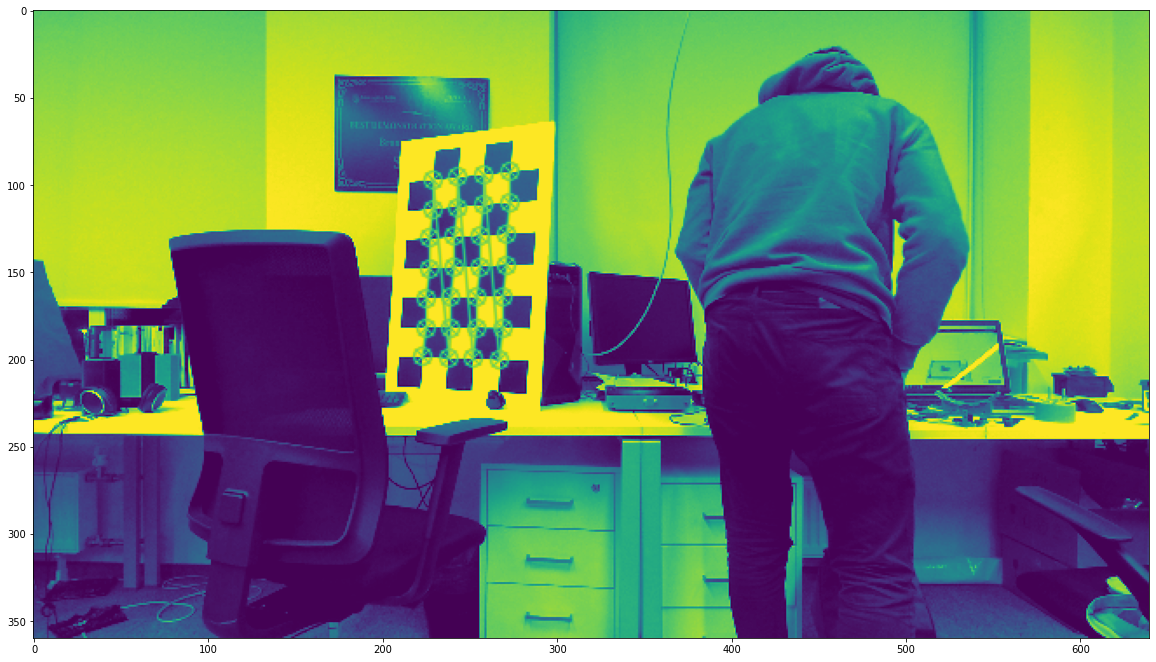

In [293]:
img1_with_corners = cv2.drawChessboardCorners(grayR_small, (chessboard_params[0], chessboard_params[1]), points1, True)
img2_with_corners = cv2.drawChessboardCorners(grayL, (chessboard_params[0], chessboard_params[1]), imgpoints2[0], True)
print(img1_with_corners)
plt.figure(figsize=(20, 20))
plt.imshow(img2_with_corners)
#cv2.imshow('img_right',img2_with_corners)


In [296]:
img1_with_corners.shape == img2_with_corners.shape

True

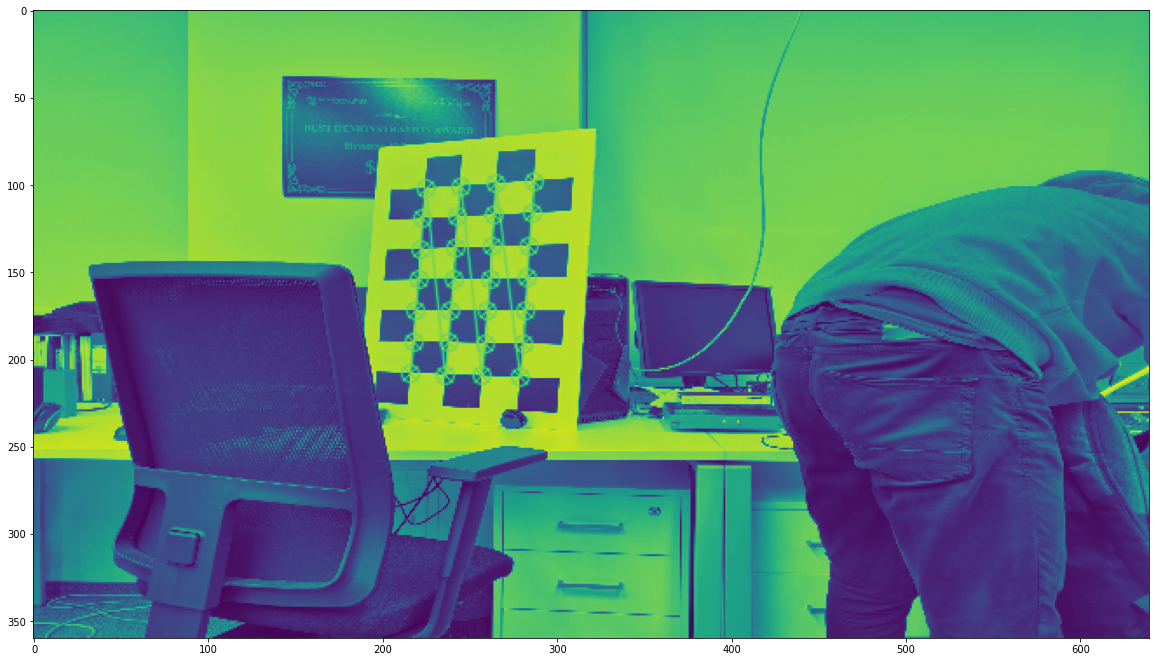

In [294]:
plt.figure(figsize=(20, 20))
plt.imshow(img1_with_corners)

In [35]:
cv2.destroyAllWindows()

In [202]:
dst1

array([[ 58,  97, 136, ...,  94,  96, 102],
       [207, 207, 208, ...,  74,  72,  68],
       [207, 210, 207, ...,  56,  59,  56],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [79]:
imgsize

(640, 360)

In [305]:
R1, R2, P1, P2, Q, validPixROI1, validPixROI2 = cv2.stereoRectify(intrinsics1, dist1, intrinsics2, dist2, imgsize, R, T, flags=cv2.CALIB_ZERO_DISPARITY, alpha=1., newImageSize=imgsize)


In [306]:
map1x,map1y = cv2.initUndistortRectifyMap(intrinsics1, dist1, R1, P1[:3, :3], imgsize, cv2.CV_32FC1)

In [307]:
map2x,map2y = cv2.initUndistortRectifyMap(intrinsics2, dist2, R2, P2[:3, :3], imgsize, cv2.CV_32FC1)

In [69]:
grayR

array([[173, 176, 178, ...,  91, 118, 104],
       [174, 174, 178, ...,  86,  94,  91],
       [172, 174, 178, ..., 104,  94,  96],
       ...,
       [164, 169, 173, ...,  34,  31,  22],
       [164, 170, 172, ...,  31,  25,  23],
       [165, 169, 173, ...,  30,  25,  22]], dtype=uint8)

In [266]:
imgpoints1[0][0,0] / a[1][0][0, 0]

5.716439

In [275]:
imgpoints1[0][0,1] / a[1][0][0, 1]

7.614418

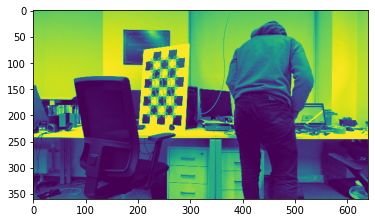

In [308]:
plt.imshow(grayL)

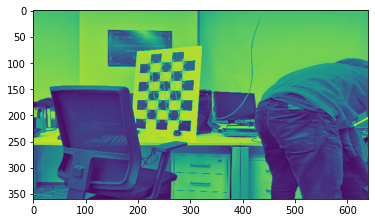

In [309]:
plt.imshow(grayR_small)

In [311]:
imgR1 = cv2.remap(grayR_small, map1x, map1y, cv2.INTER_LINEAR)
imgL1 = cv2.remap(grayL, map2x, map2y, cv2.INTER_LINEAR)

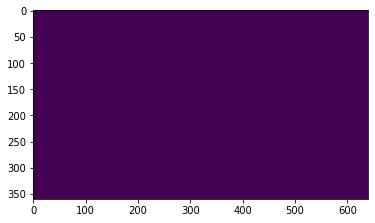

In [312]:
plt.imshow(imgR1)

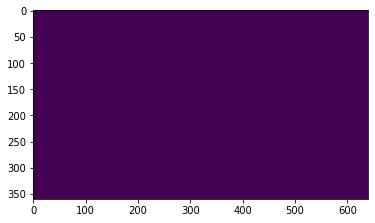

In [313]:
plt.imshow(imgL1)

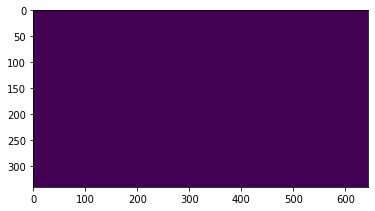

In [59]:
plt.imshow(imgR1)

In [61]:
imgR.shape

(360, 640)

In [62]:
imgL.shape

(360, 640)

In [103]:
grayL.shape

(336, 615)

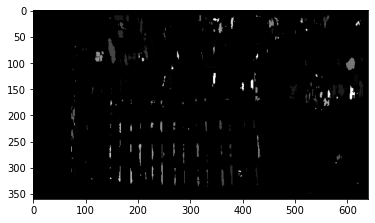

In [166]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
stereo = cv.StereoBM_create()
disparity = stereo.compute(grayL,grayR)
plt.imshow(disparity,'gray')
plt.show()

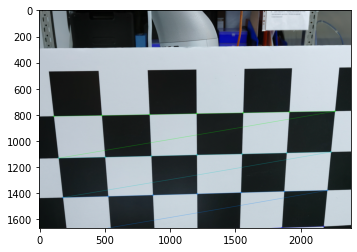

In [80]:
plt.imshow(cv2.imread(f'./{name}_{pos}.png/calib_result.png'))

In [74]:
calibrate_single('./kinect_calibration/', '')

['kinect_im.png', 'kinect_im_2.png']
kinect_im.png
kinect_im_2.png


NameError: name 'intrinsics' is not defined

In [13]:
chessboard_params = (7, 4)
def scan_board(device, dr, name):
    # generate robot_positions
    for pos in robot_positions:
        # move robot to position
        if isinstance(device, kinect.Kinect):
            img, *_ = device.snap_frame()
            folder = 'kinect_calibration'
            device.stop()

        if isinstance(device, realsense.RealSense):
            folder = 'realsense_calibration'
            img, *_ = device.get_frames(d)
            device.stop()

        if isinstance(d, phones.HuaweiDevic):
            folder = 'huawei_calibration'
            device.snap_image()

        if not os.path.exists(f'{dr}/{folder}'):
                os.mkdir(f'{dr}/{folder}')
        
        if isinstance(device, phones.HuaweiDevic):
            device.pull_img(f'{dr}/{folder}/{name}_{pos}.png')
            device.clear()
        else:
            cv2.imwrite(f'{dr}/{folder}/{name}_{pos}.png', img)

    return folder

def calibrate_procedure(devices, dr='.'):
    # calibrate each device separately
    name = 'chessboard'
    for d in devices:
        folder = scan_board(device=d, dr=dr, name=name) 
            
        intrinsics, *_ = calibrate_single(folder=f'{dr}/{folder}', img_name=name, width=chessboard_params[0], height=chessboard_params[-1])
        
        
        # do calibration for pairs

In [96]:
intrinsics, dist, chess_img_point = calibrate_single('./kinect_calibration/kinect_im.png')

In [97]:
cv2.imwrite(f'./{dr}/chess_with_points.png', chess_img_point)

True

In [82]:
h, w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(intrinsics, dist, (w,h), 1, (w,h))

In [87]:
# undistort
dst = cv2.undistort(img, intrinsics, dist, None, newcameramtx)
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv2.imwrite(f'./{dr}/calib_result.png', dst)

True

In [90]:
# undistort
mapx, mapy = cv2.initUndistortRectifyMap(intrinsics, dist, None, newcameramtx, (w,h), 5)
dst = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv2.imwrite(f'./{dr}/calib_result.png', dst)

True